<a href="https://colab.research.google.com/github/sungjuGit/COSMOS_Ju/blob/main/COSMOS_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Multilayer Perceptron

In this series, we'll be building machine learning models to perform image classification using PyTorch.

In this first notebook, we'll start with one of the most basic neural network architectures, a multilayer perceptron (MLP), also known as a feedforward network.

The dataset we'll be using is the famous MNIST dataset, a dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

We'll process the dataset, build our model, and then train our model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import time

In [3]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The first thing we'll do is load our dataset. This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [4]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 468881371.88it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39535148.11it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 198356318.38it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20353129.03it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one.

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [5]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`.

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artificially creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image.

In [6]:
# @title Transform data
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [7]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

We can simply check the `len` of the datasets to see how many examples are within each.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

In [9]:
# @title Plot Images function
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Let's load 25 images. These will have been processed through our transforms, so will be randomly rotated and cropped.

It's a good practice to see your data with your transforms applied, so you can ensure they look sensible. For example, it wouldn't make sense to flip the digits horizontally or vertically unless you are expecting to see what in your test data.

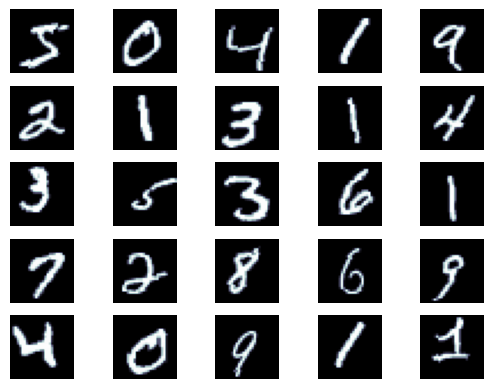

In [10]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

Next, we'll define a `DataLoader` for each of the training and test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [11]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. The image below shows the archicture of the model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 *features*. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions. Then, another hidden layer, which will transform it to 100 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

The transformation between 784 to 250, 250 to 100 and 100 to 10 dimensions are done by `Linear` layers. These are also known as fully connected or affine layers. In these layers, every element in one layer is connected to every element in the next. We can think of these elements as *neurons*, as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons.

Each connection between a neuron in one layer and a neuron in the next has a *weight* associated with it. The input to one neuron is the sum of the weighted values of all neurons in the previous layer connected to it, plus a bias term. The neuron then applies an *activation function* to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs.

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer, and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way, it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).

In [26]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = nn.Sequential(
          nn.Flatten(),
          nn.Linear(INPUT_DIM,250),
          nn.ReLU(),
          nn.Linear(250,100),
          nn.ReLU(),
          nn.Linear(100,OUTPUT_DIM)
        )

Let's calculate the number of trainable parameters (weights and biases) in our model.

In [27]:
# @title Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

### Training the Model

- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter


In [28]:
optimizer = optim.Adam(model.parameters())

We use as our loss `CrossEntropyLoss`

In [29]:
loss_fn = nn.CrossEntropyLoss()

In [30]:
# @title Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = loss_fn.to(device)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [17]:
# @title Function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, loader, optimizer, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in loader:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

The final step before training is to define a small function to tell us how long an epoch took.

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [33]:
EPOCHS = 10

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.380 | Train Acc: 88.23%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.163 | Train Acc: 95.02%
Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.128 | Train Acc: 96.06%
Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.115 | Train Acc: 96.45%
Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.101 | Train Acc: 96.72%
Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.094 | Train Acc: 97.07%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.086 | Train Acc: 97.33%
Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 0.083 | Train Acc: 97.44%
Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.080 | Train Acc: 97.47%
Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.074 | Train Acc: 97.70%


tensor([1], device='cuda:0')


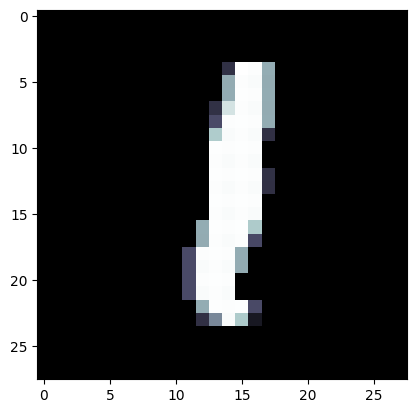

In [42]:
test_idx = 9489 # out of 10000

model.eval()

with torch.no_grad():
  test_pred = model(test_data[test_idx][0].to(device))
  prob = torch.softmax(test_pred, dim=-1)
  print(torch.argmax(prob, 1))

plt.imshow(test_data[test_idx][0].view(28, 28).cpu().numpy(), cmap='bone')


The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory.

In [32]:
def evaluate(model, loader, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [25]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.050 | Test Acc: 98.27%
